In [12]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

#Keras imports
from keras.layers import Input, Dense
from keras.optimizers import RMSprop, SGD, Adagrad,Adam,Adadelta,Adamax, Nadam
from keras.models import Sequential, Model
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers import Dense, Lambda, BatchNormalization
from keras.optimizers import SGD, Adagrad, Adam
from keras.wrappers.scikit_learn import KerasRegressor

import multiprocessing as mp


In [2]:
#LINEAR
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

#Guardar en csv columnas desde start hasta en de un dataframe.
def store_column_pd(df,columns_start,columns_end,url):
    temp_df =df.iloc[:,columns_start:columns_end]
    temp_df.to_csv(url)
    return temp_df


In [91]:
#load vectores de 10000 dimensiones
data_train = pd.read_csv("/home/daniel/Documentos/ML/rhassan/graph-edit-distance/featuresVectorByQuery.csv")
data_val = pd.read_csv("/home/daniel/Documentos/ML/rhassan/graph-edit-distance/val.csv")
data_test = pd.read_csv("/home/daniel/Documentos/ML/rhassan/graph-edit-distance/test.csv")

df_train1000 = store_column_pd(
    data_train,0,1000,
    "/home/daniel/Documentos/ML/rhassan/graph-edit-distance/featuresVectorByQuery1000.csv")


df_val1000 = store_column_pd(
    data_val,0,1000,
    "/home/daniel/Documentos/ML/rhassan/graph-edit-distance/featuresVectorByQuery1000_val.csv")

df_test1000 = store_column_pd(
    data_test,0,1000,
    "/home/daniel/Documentos/ML/rhassan/graph-edit-distance/featuresVectorByQuery1000_test.csv")

In [3]:
#Data from files
data_algebra = pd.read_csv("/home/dcasals/graph-edit-distance/data/algebra_features.txt")
data_medoids = pd.read_csv("/home/dcasals/graph-edit-distance/data/vectors_medoids.csv")
print(data_algebra.shape,data_medoids.shape)

(19171, 28) (19113, 28)


In [4]:
result = data_algebra.merge(data_medoids,
                 left_on='query_id',right_on='id')
print(result.shape)
result.head()

(19113, 56)


,query_id,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,...,pcs25.16,pcs25.17,pcs25.18,pcs25.19,pcs25.20,pcs25.21,pcs25.22,pcs25.23,pcs25.24,Unnamed: 27_y
0,http://lsq.aksw.org/res/DBpedia-q113812,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.333333,0.500000,0.400000,0.285714,0.200000,0.333333,0.200000,0.200000,NaN
1,http://lsq.aksw.org/res/DBpedia-q113813,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846,NaN
2,http://lsq.aksw.org/res/DBpedia-q113814,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846,NaN
3,http://lsq.aksw.org/res/DBpedia-q113815,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.200000,0.333333,0.333333,0.285714,0.400000,0.200000,0.333333,0.200000,0.200000,NaN
4,http://lsq.aksw.org/res/DBpedia-q113817,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.250000,0.400000,0.666667,0.250000,0.181818,0.250000,0.166667,0.166667,NaN


In [5]:
result = result.drop(columns=["query_id","id","Unnamed: 27_x","Unnamed: 27_y"])
result.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'path*', 'pathN*', 'path+', 'pathN+', 'notoneof',
       'tolist', 'order', 'project', 'distinct', 'reduced', 'multi', 'top',
       'group', 'assign', 'sequence', 'slice', 'treesize', 'time', 'pcs25',
       'pcs25.1', 'pcs25.2', 'pcs25.3', 'pcs25.4', 'pcs25.5', 'pcs25.6',
       'pcs25.7', 'pcs25.8', 'pcs25.9', 'pcs25.10', 'pcs25.11', 'pcs25.12',
       'pcs25.13', 'pcs25.14', 'pcs25.15', 'pcs25.16', 'pcs25.17', 'pcs25.18',
       'pcs25.19', 'pcs25.20', 'pcs25.21', 'pcs25.22', 'pcs25.23', 'pcs25.24'],
      dtype='object')

In [6]:
result.describe()

,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,path*,...,pcs25.15,pcs25.16,pcs25.17,pcs25.18,pcs25.19,pcs25.20,pcs25.21,pcs25.22,pcs25.23,pcs25.24
count,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.0,...,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000
mean,2.791817,2.368179,0.067860,0.680322,0.626903,0.200387,0.000314,0.001570,0.000052,0.0,...,0.432244,0.198616,0.366060,0.344247,0.419878,0.306780,0.186979,0.366060,0.223885,0.223885
std,2.424699,2.342441,0.295156,1.206685,1.607434,0.442043,0.017716,0.039588,0.007233,0.0,...,0.213312,0.133551,0.257537,0.109948,0.210350,0.114668,0.028742,0.257537,0.138379,0.138379
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.039216,0.045455,0.042553,0.040000,0.039216,0.042553,0.041667,0.042553,0.045455,0.045455
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.222222,0.133333,0.222222,0.250000,0.222222,0.222222,0.166667,0.222222,0.153846,0.153846
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.400000,0.153846,0.285714,0.400000,0.400000,0.250000,0.200000,0.285714,0.181818,0.181818
75%,4.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.666667,0.200000,0.333333,0.400000,0.666667,0.400000,0.200000,0.333333,0.222222,0.222222
max,36.000000,27.000000,4.000000,21.000000,14.000000,9.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
nunique = result.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("Remove columns with same values: {}".format(cols_to_drop))
result = result.drop(cols_to_drop, axis=1)
result.head()

Remove columns with same values: Index(['path*', 'pathN*', 'path+', 'pathN+', 'notoneof', 'tolist', 'multi',
       'top', 'assign', 'sequence'],
      dtype='object')


,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,order,...,pcs25.15,pcs25.16,pcs25.17,pcs25.18,pcs25.19,pcs25.20,pcs25.21,pcs25.22,pcs25.23,pcs25.24
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.166667,0.333333,0.500000,0.400000,0.285714,0.200000,0.333333,0.200000,0.200000
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
3,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.200000,0.333333,0.333333,0.285714,0.400000,0.200000,0.333333,0.200000,0.200000
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.250000,0.181818,0.250000,0.166667,0.166667


In [8]:
new_cols = list(result.columns[:-25]) + ['pcs'+str(i) for i in list(range(0,25))]
result.columns = new_cols

In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(
    result.drop(columns=['time']), result['time'], test_size=0.25, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.30, random_state=42,shuffle=True)
print("Shapes : Train: {} Val: {}, Test: {}".format(X_train.shape, X_val.shape, X_test.shape))

Shapes : Train: (10033, 41) Val: (4301, 41), Test: (4779, 41)


In [10]:
X_train.head()

,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,order,...,pcs15,pcs16,pcs17,pcs18,pcs19,pcs20,pcs21,pcs22,pcs23,pcs24
9793,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
3416,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.222222,0.166667,0.250000,0.166667,0.166667
8020,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.200000,0.333333,0.333333,0.285714,0.400000,0.200000,0.333333,0.200000,0.200000
13722,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.250000,0.181818,0.250000,0.166667,0.166667
11534,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846


In [12]:
#Standarizar
scalerx = StandardScaler()
x_train_scaled = scalerx.fit_transform(X_train);
x_val_scaled = scalerx.transform(X_val);
x_test_scaled = scalerx.fit_transform(X_test);

scaled_df_train = pd.DataFrame(x_train_scaled, index=X_train.index, columns=X_train.columns)
scaled_df_val = pd.DataFrame(x_val_scaled, index=X_val.index, columns=X_train.columns)
scaled_df_test = pd.DataFrame(x_test_scaled, index=X_test.index, columns=X_train.columns)

In [3]:
#Save data
scaled_df_train.join(y_train).to_csv("/home/dcasals/jupyter/mlproject/xtrain_std.csv", index=False)
scaled_df_val.join(y_val).to_csv("/home/dcasals/jupyter/mlproject/xval_std.csv", index=False)
scaled_df_test.join(y_test).to_csv("/home/dcasals/jupyter/mlproject/xtest_std.csv", index=False)

NameError: name 'scaled_df_train' is not defined

In [3]:
#READ data
scaled_df_train = pd.read_csv("/home/dcasals/jupyter/mlproject/xtrain_std.csv")
scaled_df_val   = pd.read_csv("/home/dcasals/jupyter/mlproject/xval_std.csv")
scaled_df_test  = pd.read_csv("/home/dcasals/jupyter/mlproject/xtest_std.csv")

y_train = scaled_df_train['time']
y_val   = scaled_df_val['time']
y_test  = scaled_df_test['time']
scaled_df_train = scaled_df_train.drop(columns=['time'])
scaled_df_val = scaled_df_val.drop(columns=['time'])
scaled_df_test = scaled_df_test.drop(columns=['time'])

In [4]:
#Pass Target to log scale
y_train_log = np.log(y_train.values.reshape(-1, 1))
y_val_log = np.log(y_val.values.reshape(-1, 1))
y_test_log = np.log(y_test.values.reshape(-1, 1))

#Standarizar target
scalery = StandardScaler()
y_train_log_std = scalery.fit_transform(y_train_log)
y_val_log_std = scalery.transform(y_val_log)
y_test_log_std = scalery.transform(y_test_log)

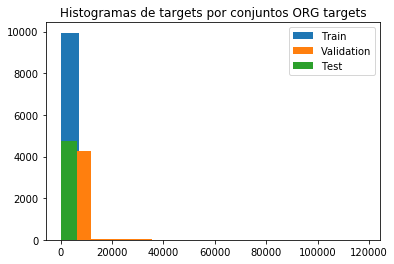

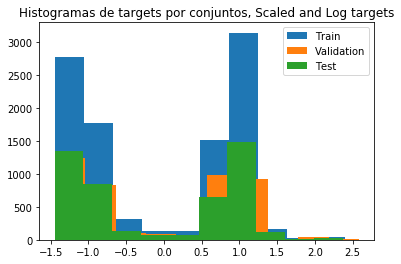

In [17]:
plt.title("Histogramas de targets por conjuntos ORG targets")
plt.hist(y_train.values.reshape(-1, 1),label="Train")
plt.hist(y_val.values.reshape(-1, 1),label="Validation")
plt.hist(y_test.values.reshape(-1, 1),label="Test")
plt.legend()
plt.show()
plt.title("Histogramas de targets por conjuntos, Scaled and Log targets")
plt.hist(y_train_log_std,label="Train")
plt.hist(y_val_log_std,label="Validation")
plt.hist(y_test_log_std,label="Test")
plt.legend()
plt.show()

In [43]:
var1 = None
def p(var1):
    if var1 is None:
        var1 = True
        print("HOla")
p(var1)
var1

HOla


<span style="color:blue">

### Entrenando RNN. Primer enfoque

- Datos escalados
- Targets escalados y en escala logarítmica.


In [5]:
# Set callback functions to early stop training and save the best model so far
def tune_params(optimizer, n1, n2, n3, dropout_rate, epochs, batch_size):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=30)]

    model = Sequential()
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n3, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae', coeff_determination, rmse])
    history_org = model.fit(scaled_df_train.values, y_train_log_std,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(scaled_df_val.values, y_val_log_std),
                    callbacks=callbacks_best,
                    verbose=False
                     )
    print(model.summary())

    #Prediction
    y_pred_org_train = np.exp(scalery.inverse_transform(model.predict(scaled_df_train.values).reshape(-1, 1)))
    y_pred_org_val = np.exp(scalery.inverse_transform(model.predict(scaled_df_val.values).reshape(-1, 1)))

    rmse_train = np.sqrt(mean_squared_error(y_pred_org_train, y_train))
    rmseval = np.sqrt(mean_squared_error(y_pred_org_val, y_val))
    
    print("RMSE Train", np.sqrt(mean_squared_error(y_pred_org_train, y_train)))
    print("RMSE VAL", np.sqrt(mean_squared_error(y_pred_org_val, y_val)))
    if best_rmse is None or best_rmse > rmseval:
        best_model = model
        best_epochs = epochs
        best_rmse = rmseval
        print("Best rmse: {}".format(rmseval))
        best_optimizer = optimizer
#     plt.scatter(y_pred_org_train,y_train)
#     plt.xlabel("Prediction in Train")
#     plt.show()

#     plt.scatter(y_pred_org_val,y_val)
#     plt.xlabel("Pred in Val")
    plt.show()
    return model

In [ ]:
best_model = None
best_epochs = 250
best_rmse = -1
best_optimiz = SGD(learning_rate=0.0001)
optimizers = [SGD(learning_rate=0.0001), RMSprop(learning_rate=0.0001), Adagrad(learning_rate=0.0001),
              Adadelta(learning_rate=0.0001), Adam(learning_rate=0.0001), Adamax(learning_rate=0.0001),
                                                                                Nadam(learning_rate=0.0001)]
for neurons1 in :
    for optimiz in optimizers:
        tune_params(optimiz, 80, 80, 110, best_epochs,best_model,best_epochs,best_rmse,best_optimiz)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 80)                3360      
_________________________________________________________________
dropout_34 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 80)                6480      
_________________________________________________________________
dropout_35 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 80)                6480      
_________________________________________________________________
dropout_36 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)               

In [6]:
def gridSearch_neural_network(df_train, ytrain):

    # evaluate model with standardized dataset
    estimator = KerasRegressor(build_fn=tune_params, verbose=0)
    
    # grid search epochs, batch size and optimizer
    optimizers = [SGD(learning_rate=0.0001), RMSprop(learning_rate=0.0001), Adagrad(learning_rate=0.0001),
              Adadelta(learning_rate=0.0001), Adam(learning_rate=0.0001), Adamax(learning_rate=0.0001),
                                                                                Nadam(learning_rate=0.0001)]

    dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    neurons1 = list(range(80,300,30))
    neurons2 = list(range(80,300,30))
    neurons3 = list(range(80,300,30))
    epochs   = list(range(250,450,50))
    batches  = list(range(30,120,20))
    param_grid = dict(optimizer   = optimizers,
                      n1    = neurons1,
                      n2    = neurons2,
                      n3    = neurons3,
                      dropout_rate= dropout_rate, 
                      epochs      = epochs, 
                      batch_size  = batches
                      )

    grid = GridSearchCV(estimator=estimator, param_grid=param_grid)
    grid_result = grid.fit(df_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [13]:
gridSearch_neural_network(scaled_df_train.values, y_train_log_std)

/home/dcasals/rnn/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                3360      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

/home/dcasals/rnn/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


UnboundLocalError: local variable 'best_rmse' referenced before assignment

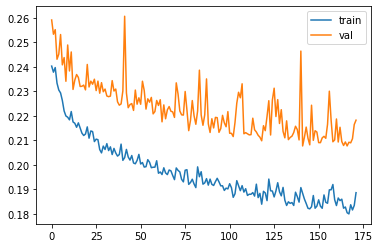

     4.372,       4.000
     3.715,       3.000
   546.175,     559.000
  1578.228,    1933.000
     4.372,       3.000
   568.925,     511.000
     3.504,       2.000
   657.449,     519.000
  1901.544,    2391.000
    19.381,       3.000
  1395.322,    1414.000
     3.604,       2.000
  1107.567,    1353.000
     3.810,       3.000
    12.093,    1047.000
   869.091,     654.000
  1838.780,    2007.000
   211.226,       3.000
     4.372,       4.000
     4.372,       4.000
     3.604,    2229.000
   869.091,     634.000
     3.715,       3.000
   653.638,     736.000
     4.372,       4.000
     4.372,       4.000
     3.715,       2.000
    12.093,       2.000
  1621.417,    1813.000
    21.194,    2151.000
    21.194,      78.000
     4.372,       4.000
   172.254,       5.000
  1444.731,    1571.000
     4.372,       4.000
   869.091,     855.000
    10.296,       4.000
     3.810,    1784.000
  1894.068,    2532.000
     3.667,       3.000
   616.779,    2029.000
     3.810,     

In [21]:
plt.plot(history_org.history['loss'][13:],label="train")
plt.plot(history_org.history['val_loss'][13:],label="val")
plt.legend()
plt.show()
a = y_pred_org_val.reshape(1, -1)
for i in range(y_val.shape[0]):
#     print(y_val[i])
    print("%10.3f,  %10.3f"%(a[0][i],y_val.values[i]))
# y_val['ex_time']
# b = y_pred_org_test.reshape(1, -1)
# for i in range(y_test.shape[0]):
# #     print(y_val[i])
#     print("%10.3f,  %10.3f"%(b[0][i],y_test['ex_time'][i]))

In [106]:
# Set callback functions to early stop training and save the best model so far
callbacks_best = [EarlyStopping(monitor='val_loss', patience=10),
            ]
# def autoencode_pd(df):
# this is the size of our encoded representations
encoding_dim = 200  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(new.shape[1],))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(new.shape[1], activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='Adagrad', loss='mse')
autoencoder.fit(std_all_df_train, std_all_df_train,
                epochs=120,
                #batch_size=60,
                shuffle=True,
                validation_data=(std__alldf_val, std__alldf_val),
                callbacks=callbacks_best)


Train on 3600 samples, validate on 1200 samples
Epoch 1/120
3600/3600 [==============================] - 2s 654us/step - loss: 0.0809 - val_loss: 0.0472
Epoch 2/120
3600/3600 [==============================] - 2s 475us/step - loss: 0.0500 - val_loss: 0.0390
Epoch 3/120
3600/3600 [==============================] - 2s 485us/step - loss: 0.0361 - val_loss: 0.0343
Epoch 4/120
3600/3600 [==============================] - 2s 482us/step - loss: 0.0299 - val_loss: 0.0297
Epoch 5/120
3600/3600 [==============================] - 2s 473us/step - loss: 0.0261 - val_loss: 0.0267
Epoch 6/120
3600/3600 [==============================] - 2s 534us/step - loss: 0.0230 - val_loss: 0.0237
Epoch 7/120
3600/3600 [==============================] - 2s 481us/step - loss: 0.0204 - val_loss: 0.0223
Epoch 8/120
3600/3600 [==============================] - 2s 499us/step - loss: 0.0183 - val_loss: 0.0199
Epoch 9/120
3600/3600 [==============================] - 2s 488us/step - loss: 0.0162 - val_loss: 0.0197
Epoch 1

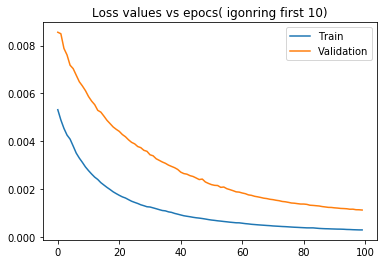

In [107]:
plt.plot(autoencoder.history.history['loss'][20:],label="Train")
plt.plot(autoencoder.history.history['val_loss'][20:],label="Validation")
plt.title("Loss values vs epocs( igonring first 10)")
plt.legend()
plt.show()

In [109]:
autoencoder.save("autoencoder.h5")
encoder.save("encoder.h5")

In [135]:
encoded_layer = autoencoder.layers[1]
weights_encoder = encoded_layer.get_weights()
print(len(weights_encoder[0]),len(weights_encoder[1]))

1026 200


In [113]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 1026)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)               205400    
_________________________________________________________________
dense_29 (Dense)             (None, 1026)              206226    
Total params: 411,626
Trainable params: 411,626
Non-trainable params: 0
_________________________________________________________________


In [137]:
std_all_df_train.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'path*',
       ...
       '<http://dbpedia.org/property/u>',
       '<http://dbpedia.org/ontology/revenue>',
       '<http://dbpedia.org/property/ft>',
       '<http://dbpedia.org/property/commitdate>',
       '<http://dbpedia.org/property/direction>',
       '<http://dbpedia.org/property/nickname>',
       '<http://dbpedia.org/property/parliament>',
       '<http://dbpedia.org/property/seatChange>',
       '<http://dbpedia.org/property/powers>',
       '<http://dbpedia.org/ontology/formationDate>'],
      dtype='object', length=1026)

**Se entrenan el modelo secuencial con datos originales.**

In [138]:
#Load from file
df_org_train = pd.read_csv("/home/daniel/Documentos/ML/rhassan/query-performance/6000/xtrain_std_oldcolumns.csv")
df_org_val = pd.read_csv("/home/daniel/Documentos/ML/rhassan/query-performance/6000/xval_std_oldcolumns.csv")
df_org_test = pd.read_csv("/home/daniel/Documentos/ML/rhassan/query-performance/6000/xtest_std_oldcolumns.csv")

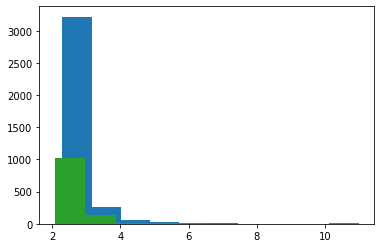

train log min ex_time    2.302585
dtype: float64 train min ex_time    10
dtype: int64
train log max ex_time    10.865325
dtype: float64 train max ex_time    52330
dtype: int64
Shape (157, 36)


In [210]:
plt.hist(y_train_log.values)
plt.hist(y_val_log.values)
plt.hist(y_test_log.values)
plt.show()

y_train_log_min = np.min(y_train_log)
y_train_min = np.min(y_train)

y_train_log_max = np.max(y_train_log)
y_train_max = np.max(y_train)

print("train log min", y_train_log_min,"train min", y_train_min)
print("train log max",y_train_log_max,"train max",y_train_max)
print("Shape",np.unique(df_org_train,axis=0).shape)

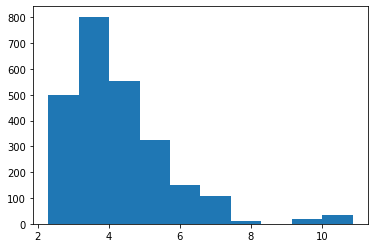

In [256]:
#Load from file
datt= df_org_train.join(y_train)
datv= df_org_val.join(y_val)
dattest= df_org_test.join(y_test)

df_org_mayor = datt.loc[(np.log(datt['ex_time']) >= 1.5) & (np.log(datt['ex_time']) <= 2.6)].sample(n=500,random_state=42)
df_org_minor = datt.loc[(np.log(datt['ex_time']) < 1.5) | (np.log(datt['ex_time']) > 3.5)].sample(n=2000,replace=True)
df_org_2 = pd.concat([df_org_mayor,df_org_minor])
# df_org_val1 = datv.loc[datv['ex_time'] < 2000]

# df_org_test1 = dattest.loc[dattest['ex_time'] < 2000]

plt.hist(np.log(df_org_2['ex_time']).values)
plt.hist(np.log(y_val_log).values)
plt.hist(np.log(y_test_log).values)
plt.show()

In [318]:
y_train_log

array([2.56494936, 2.56494936, 2.48490665, ..., 4.86753445, 4.79579055,
       3.71357207])

In [267]:
#Pass Target to log scale
y_train = df_org_2['ex_time'].values
y_train_log = np.log(y_train)
# # #Standarice target
scaler = StandardScaler()
y_train_log_std = scaler.fit_transform(y_train_log.reshape(-1, 1))
y_val_log_std = scaler.transform(y_val_log)
y_test_log_std = scaler.transform(y_test_log)

Train on 2500 samples, validate on 1200 samples
Epoch 1/300
2500/2500 [==============================] - 2s 762us/step - loss: 1.8874 - mean_squared_error: 1.8874 - mean_absolute_error: 0.9729 - coeff_determination: -1.0839 - rmse: 7.2742 - val_loss: 1.2463 - val_mean_squared_error: 1.2463 - val_mean_absolute_error: 1.0892 - val_coeff_determination: -44.2598 - val_rmse: 3.0621
Epoch 2/300
2500/2500 [==============================] - 0s 145us/step - loss: 1.4249 - mean_squared_error: 1.4249 - mean_absolute_error: 0.8761 - coeff_determination: -0.5725 - rmse: 5.6830 - val_loss: 1.3315 - val_mean_squared_error: 1.3315 - val_mean_absolute_error: 1.1219 - val_coeff_determination: -47.4760 - val_rmse: 3.1905
Epoch 3/300
2500/2500 [==============================] - 0s 153us/step - loss: 1.2775 - mean_squared_error: 1.2775 - mean_absolute_error: 0.8294 - coeff_determination: -0.3776 - rmse: 4.6567 - val_loss: 1.3467 - val_mean_squared_error: 1.3467 - val_mean_absolute_error: 1.1259 - val_coeff

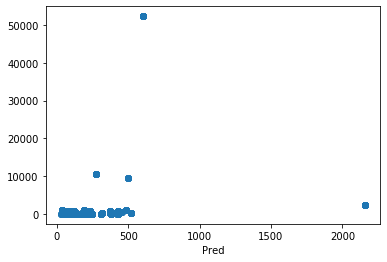

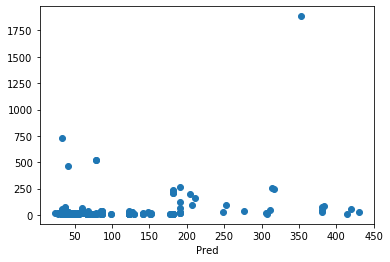

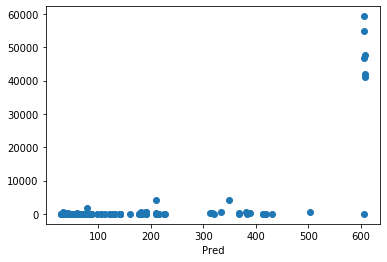

In [314]:
# df_org_2 = df_org_2.drop(['ex_time'], axis=1)

# Set callback functions to early stop training and save the best model so far
callbacks_best = [EarlyStopping(monitor='val_loss', patience=50)]
optimizer = SGD(lr=0.0001)
# optimizer = 'adam'

model = Sequential()
model.add(Dense(95, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae',coeff_determination,rmse])
history_org = model.fit(df_org_2.values, y_train_log_std,
                epochs=300,
                #batch_size=80,
                validation_data=(df_org_val, y_val_log_std),
                callbacks=callbacks_best
                 )
#Prediction
y_pred_org_train = np.exp(scaler.inverse_transform(model.predict(df_org_2.values).reshape(-1, 1)))
y_pred_org_val = np.exp(scaler.inverse_transform(model.predict(df_org_val.values).reshape(-1, 1)))
y_pred_org_test = np.exp(scaler.inverse_transform(model.predict(df_org_test.values).reshape(-1, 1)))

print("RMSE Train", np.sqrt(mean_squared_error(y_pred_org_train, y_train)))
print("RMSE VAL", np.sqrt(mean_squared_error(y_pred_org_val, y_val)))
print("RMSE TEST", np.sqrt(mean_squared_error(y_pred_org_test, y_test)))

plt.scatter(y_pred_org_train,y_train)
plt.xlabel("Pred")
plt.show()

plt.scatter(y_pred_org_val,y_val)
plt.xlabel("Pred")
plt.show()

plt.scatter(y_pred_org_test,y_test)
plt.xlabel("Pred")
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 95)                3515      
_________________________________________________________________
dense_73 (Dense)             (None, 150)               14400     
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 151       
Total params: 18,066
Trainable params: 18,066
Non-trainable params: 0
_________________________________________________________________
None


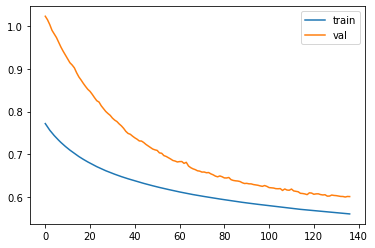

    34.628,      13.000
    45.556,      15.000
    42.021,      16.000
    33.426,      17.000
    34.620,      16.000
    39.834,      13.000
    36.988,      12.000
    36.364,      12.000
    84.694,      26.000
    34.954,      12.000
    34.954,      12.000
    33.426,      13.000
    42.965,      11.000
    33.425,      12.000
    42.965,      12.000
    33.155,      13.000
    34.628,      14.000
    34.624,      11.000
    34.954,      13.000
    84.694,      24.000
    34.954,      12.000
    35.319,      12.000
    31.632,      12.000
    34.954,      11.000
    33.426,      14.000
    34.620,      12.000
    34.954,      13.000
    24.873,      12.000
    44.102,      14.000
    34.954,      13.000
    24.873,      12.000
    33.797,      12.000
    34.624,      11.000
    24.873,      13.000
    34.954,      12.000
    33.426,      11.000
    34.954,      12.000
    34.620,      12.000
    34.954,      13.000
    34.624,      11.000
    34.954,      12.000
    35.319,     

In [312]:
print(model.summary())
plt.plot(history_org.history['loss'][13:],label="train")
plt.plot(history_org.history['val_loss'][13:],label="val")
plt.legend()
plt.show()
a = y_pred_org_val.reshape(1, -1)
for i in range(y_val.shape[0]):
#     print(y_val[i])
    print("%10.3f,  %10.3f"%(a[0][i],y_val['ex_time'][i]))
# y_val['ex_time']
b = y_pred_org_test.reshape(1, -1)
for i in range(y_test.shape[0]):
#     print(y_val[i])
    print("%10.3f,  %10.3f"%(b[0][i],y_test['ex_time'][i]))

In [313]:
b = y_pred_org_test.reshape(1, -1)
for i in range(y_test.shape[0]):
#     print(y_val[i])
    print("%10.3f,  %10.3f"%(b[0][i],y_test['ex_time'][i]))

    31.632,      12.000
    34.954,      12.000
    27.118,      17.000
    33.426,      13.000
    34.954,      13.000
    33.426,      12.000
    33.835,      13.000
    33.426,      12.000
    33.426,      12.000
    35.319,      15.000
    34.954,      12.000
    34.954,      13.000
    34.954,      11.000
    33.426,      11.000
    34.954,      12.000
    51.986,      14.000
    44.102,      12.000
    65.555,      15.000
    34.954,      12.000
    34.954,      12.000
    33.426,      14.000
    34.620,      11.000
    34.624,      13.000
    34.954,      12.000
    34.624,      13.000
    52.037,      15.000
    92.216,      12.000
    34.624,      17.000
    34.620,      11.000
    34.954,      12.000
    34.954,      12.000
    34.954,      12.000
    33.426,      11.000
    42.965,      11.000
    34.624,      12.000
    34.954,      15.000
    34.624,      11.000
    42.965,      12.000
    34.954,      12.000
    34.954,      12.000
    34.954,      11.000
    33.426,     

RMSE Train 257.43314273277724
RMSE VAL 60.226684299286845
RMSE TEST 1415.222430121233


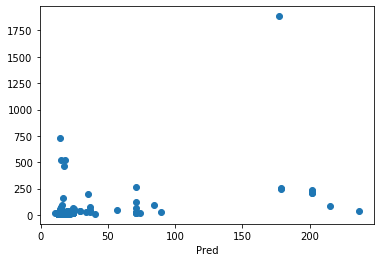

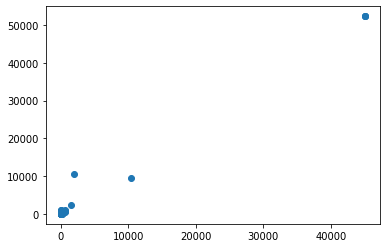

In [58]:
y_pred_val = np.exp(scaler.inverse_transform(model.predict(x_val_scaled).reshape(-1, 1)))
y_pred_train = np.exp(scaler.inverse_transform(model.predict(x_train_scaled).reshape(-1, 1)))
y_pred_test = np.exp(scaler.inverse_transform(model.predict(x_test_scaled).reshape(-1, 1)))

print("RMSE Train", np.sqrt(mean_squared_error(y_pred_train, y_datatrain)))
print("RMSE VAL", np.sqrt(mean_squared_error(y_pred_val, y_val)))
print("RMSE TEST", np.sqrt(mean_squared_error(y_pred_test, y_test)))

plt.scatter(y_pred_val,y_val)
plt.xlabel("Pred")
plt.show()
plt.scatter(y_pred_train,y_datatrain)
plt.show()


In [193]:
def coeff_determination_simple(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true - y_pred )) 
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
print(coeff_determination_simple(y_pred_org_train,y_train))
print(coeff_determination_simple(y_pred_org_val,y_val))
print(coeff_determination_simple(y_pred_org_test,y_test))

ex_time   -305.716065
dtype: float64
ex_time   -4.519423
dtype: float64
ex_time   -13378.819299
dtype: float64


In [64]:
from keras import Sequential
from keras.layers import Dense,Lambda, BatchNormalization
from keras.optimizers import SGD, Adagrad, Adam
from sklearn.utils import shuffle
# Set callback functions to early stop training and save the best model so far
callbacks_best = [EarlyStopping(monitor='val_loss', patience=50),
         #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
            ]
optimizer = SGD(lr=0.001)
#optimizer = Adagrad(lr=0.005)
#optimizer = RMSprop(0.001) 
#optimizer = 'adam'
model = Sequential()
model.add(Dense(200, input_shape=(x_train_scaled.shape[1],), activation='relu'))
#model.add(Dense(200, weights=weights, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae',coeff_determination,rmse])
model.summary
history = model.fit(x_train_scaled, y_train_log_std,
                epochs=150,
               # batch_size=20,
                validation_data=(x_val_scaled, y_val_log_std),
                callbacks=callbacks_best
                   )

y_pred_val = np.exp(scaler.inverse_transform(model.predict(x_val_scaled).reshape(-1, 1)))
y_pred_train = np.exp(scaler.inverse_transform(model.predict(x_train_scaled).reshape(-1, 1)))
y_pred_test = np.exp(scaler.inverse_transform(model.predict(x_test_s).reshape(-1, 1)))

print("RMSE Train", np.sqrt(mean_squared_error(y_pred_train, y_train)))
print("RMSE VAL", np.sqrt(mean_squared_error(y_pred_val, y_val)))
print("RMSE TEST", np.sqrt(mean_squared_error(y_pred_test, y_test)))

plt.scatter(y_pred_val,y_val)
plt.xlabel("Pred")
plt.show()
plt.scatter(y_pred_train,y_train)
plt.show()

Train on 3600 samples, validate on 1200 samples
Epoch 1/150
3600/3600 [==============================] - 2s 553us/step - loss: 1.0261 - mean_squared_error: 1.0261 - mean_absolute_error: 0.5537 - coeff_determination: -0.1667 - rmse: 707.5595 - val_loss: 0.6505 - val_mean_squared_error: 0.6505 - val_mean_absolute_error: 0.5696 - val_coeff_determination: -0.9888 - val_rmse: 4.0045
Epoch 2/150
3600/3600 [==============================] - 1s 341us/step - loss: 0.9023 - mean_squared_error: 0.9023 - mean_absolute_error: 0.5281 - coeff_determination: -0.0555 - rmse: 617.7569 - val_loss: 0.5971 - val_mean_squared_error: 0.5971 - val_mean_absolute_error: 0.5528 - val_coeff_determination: -0.9212 - val_rmse: 3.5844
Epoch 3/150
3600/3600 [==============================] - 1s 312us/step - loss: 0.8360 - mean_squared_error: 0.8360 - mean_absolute_error: 0.5064 - coeff_determination: 0.0618 - rmse: 532.6020 - val_loss: 0.5601 - val_mean_squared_error: 0.5601 - val_mean_absolute_error: 0.5318 - val_co

KeyboardInterrupt: 